# Addressing some issues with the original dataset

In [3]:
import os
from shutil import copyfile
os.makedirs('images/NORMAL', exist_ok=True)
os.makedirs('images/PNEUMONIA', exist_ok=True)

base_path = '/kaggle/input/chest-xray-pneumonia/chest_xray'

for path in ['/train', '/test', '/val']:
    for dirname, _, filenames in os.walk(base_path + path):
        for i, file in enumerate(filenames):
            img_class = dirname.split('/')[6]
            copyfile(os.path.join(dirname, file), 'images/' + img_class + '/' + file)

In [4]:
for dirname, _, filenames in os.walk('images'):
    if(len(dirname.split("/")) > 1):
        print(dirname + " has " + str(len(filenames)) + " files")

images/PNEUMONIA has 4273 files
images/NORMAL has 1583 files


Next, let's split the new image set into training and test sets.

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from shutil import rmtree

#rmtree('train') # Remove existing, if re-run
#rmtree('test') # Remove existing, if re-run

os.makedirs('train/NORMAL', exist_ok=True)
os.makedirs('train/PNEUMONIA', exist_ok=True)
os.makedirs('test/NORMAL', exist_ok=True)
os.makedirs('test/PNEUMONIA', exist_ok=True)

# Split NORMAL
train, test = train_test_split(os.listdir('images/NORMAL'), 
                               test_size=0.2, 
                               random_state=42)
for img in train:
    copyfile(os.path.join('images/NORMAL/', img), 
             os.path.join('train/NORMAL/', img))
for img in test:
    copyfile(os.path.join('images/NORMAL/', img), 
             os.path.join('test/NORMAL/', img))

# Split PNEUMONIA
train, test = train_test_split(os.listdir('images/PNEUMONIA'), 
                               test_size=0.2, 
                               random_state=42)
for img in train:
    copyfile(os.path.join('images/PNEUMONIA/', img), 
             os.path.join('train/PNEUMONIA/', img))
for img in test:
    copyfile(os.path.join('images/PNEUMONIA/', img), 
             os.path.join('test/PNEUMONIA/', img))

Let's look at some of the images, so we know what we're dealing with.

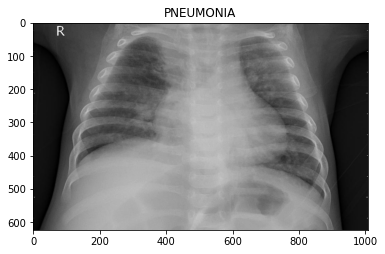

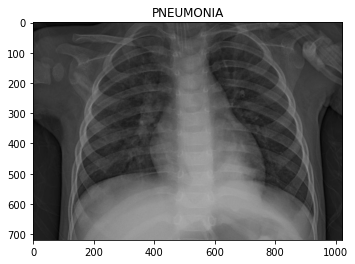

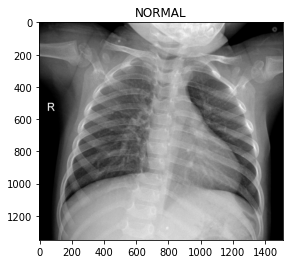

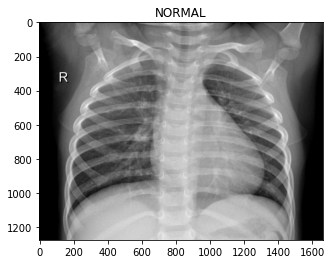

In [6]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

for dirname, _, filenames in os.walk('train'):
    for i, file in enumerate(filenames):
        if(i > 1):
            break
        plt.imshow(mpimg.imread(os.path.join(dirname, file)), cmap='gray')
        plt.title(dirname.split('/')[1])
        plt.show()

# Model

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

SIZE = 128
BATCH = 64

# image augmentations
image_gen = ImageDataGenerator(rescale=1./255,
                                rotation_range=5,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                validation_split=0.2)

# flow_from_directory generators
train_generator = image_gen\
    .flow_from_directory('train',
                        target_size=(SIZE, SIZE),
                        class_mode="binary",
                        batch_size=BATCH,
                        subset='training')

validation_generator = image_gen\
    .flow_from_directory('train',
                        target_size=(SIZE, SIZE),
                        class_mode="binary",
                        batch_size=BATCH,
                        subset='validation')

Found 3748 images belonging to 2 classes.
Found 936 images belonging to 2 classes.


In [9]:
!pip install efficientnet

In [10]:
import efficientnet.keras as efn
from tensorflow.keras.callbacks import Callback
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Recall, Precision

# Callbacks
## Keep the best model
mc = ModelCheckpoint('model.hdf5', 
                     save_best_only=True, 
                     verbose=0, 
                     monitor='val_loss', 
                     mode='min')

## Reduce learning rate if it gets stuck in a plateau
rlr = ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.3, 
                        patience=3, 
                        min_lr=0.000001, 
                        verbose=1)

# Model
## Define the base model with EfficientNet weights
model = efn.EfficientNetB4(weights = 'imagenet', 
                           include_top = False, 
                           input_shape = (SIZE, SIZE, 3))

## Output layer
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation="relu")(x)
x = Dense(32, activation="relu")(x)
predictions = Dense(1, activation="sigmoid")(x)

## Compile and run
model = Model(inputs=model.input, outputs=predictions)

model.compile(optimizer='adam',
              loss='binary_crossentropy', 
              metrics=['accuracy', Recall(), Precision()])

model_history = model.fit(train_generator,
                            validation_data=validation_generator,
                            steps_per_epoch=train_generator.n/BATCH,
                            validation_steps=validation_generator.n/BATCH,
                            epochs=15,
                            verbose=1,
                            callbacks=[mc, rlr])

Using TensorFlow backend.


71892992/71892840 [==============================] - 2s 0us/step
Epoch 1/15
59/58 [==============================] - 112s 2s/step - loss: 0.2045 - accuracy: 0.9216 - recall: 0.9314 - precision: 0.9152 - val_loss: 0.0665 - val_accuracy: 0.9530 - val_recall: 0.9502 - val_precision: 0.9471
Epoch 2/15
59/58 [==============================] - 48s 816ms/step - loss: 0.1187 - accuracy: 0.9581 - recall: 0.9585 - precision: 0.9531 - val_loss: 0.3699 - val_accuracy: 0.9498 - val_recall: 0.9631 - val_precision: 0.9569
Epoch 3/15
59/58 [==============================] - 52s 873ms/step - loss: 0.0876 - accuracy: 0.9696 - recall: 0.9673 - precision: 0.9601 - val_loss: 0.1967 - val_accuracy: 0.9038 - val_recall: 0.9703 - val_precision: 0.9593
Epoch 4/15
59/58 [==============================] - 52s 875ms/step - loss: 0.0689 - accuracy: 0.9784 - recall: 0.9729 - precision: 0.9599 - val_loss: 0.3336 - val_accuracy: 0.9017 - val_recall: 0.9751 - val_precision: 0.9601

Epoch 00004: ReduceLROnPlateau reduc

In [11]:
# Load the best model
model.load_weights("model.hdf5")

## Training performance

<Figure size 432x288 with 0 Axes>

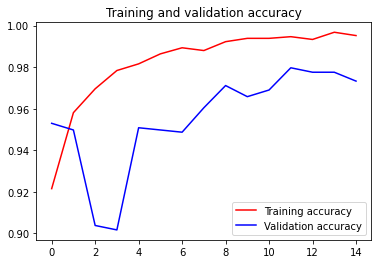

<Figure size 432x288 with 0 Axes>

In [12]:
# Plot training and validation accuracy by epoch
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# Model evaluation

Now we'll evaluate the model using the test set.

In [13]:
test_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=5,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1)

test_generator = test_datagen.flow_from_directory(
    directory="test",
    target_size=(SIZE, SIZE),
    class_mode="binary",
    shuffle=False,
    batch_size=BATCH
)

preds = model.predict_generator(generator=test_generator) # get proba predictions
labels = 1*(preds > 0.5) # convert proba to classes

Found 1172 images belonging to 2 classes.


## Confusion matrix

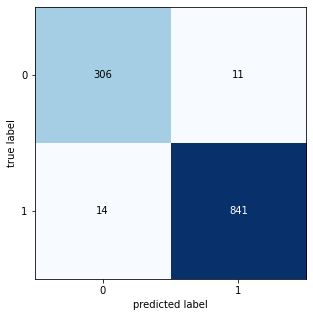

In [14]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
CM = confusion_matrix(test_generator.classes, labels)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

## Classification report

In [15]:
from sklearn.metrics import classification_report
print(classification_report(test_generator.classes, labels))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       317
           1       0.99      0.98      0.99       855

    accuracy                           0.98      1172
   macro avg       0.97      0.97      0.97      1172
weighted avg       0.98      0.98      0.98      1172



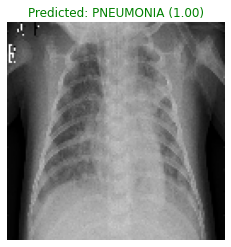

Image: /kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
Predicted Class: PNEUMONIA
Confidence Score: 1.00


In [16]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

def predict_single_image(model, image_path, class_labels):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(SIZE, SIZE))  # Resize image to match model input
    img_array = img_to_array(img) / 255.0  # Scale pixel values to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make a prediction
    prediction = model.predict(img_array)[0][0]
    predicted_class = class_labels[int(prediction > 0.5)]  # Convert to class label

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({prediction:.2f})", color="green" if prediction > 0.5 else "red")
    plt.show()

    # Print prediction result
    print(f"Image: {image_path}")
    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence Score: {prediction:.2f}")

# Define the class labels (NORMAL and PNEUMONIA in this case)
class_labels = list(test_generator.class_indices.keys())

# Path to the image to predict
image_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg"  # Replace with your image path

# Call the function
predict_single_image(model, image_path, class_labels)


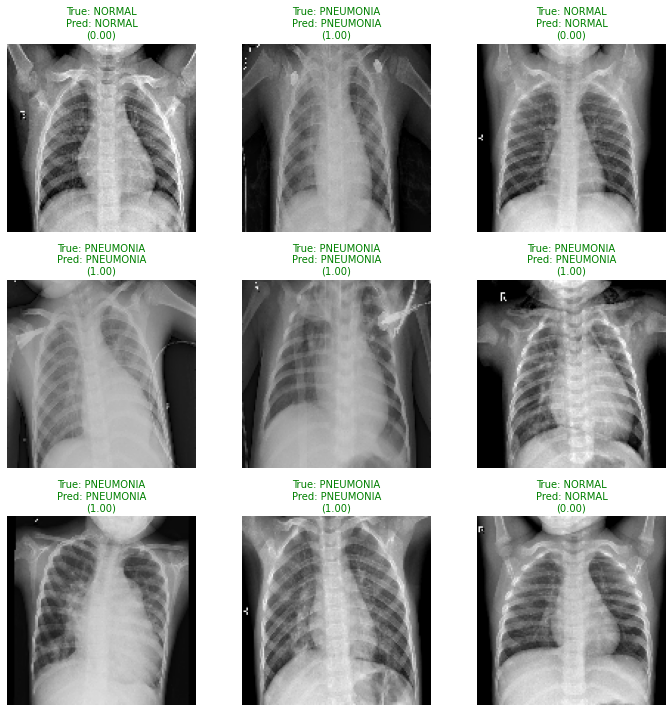

In [18]:
import random
# -------------------------
# DISPLAY RANDOM IMAGES WITH PREDICTIONS
# -------------------------

def predict_and_display_grid_with_true_labels(model, directory, class_labels, grid_size=(3, 3)):
    images = []
    true_labels = []
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):
            for file in os.listdir(class_path):
                if file.lower().endswith(('png', 'jpg', 'jpeg')):
                    images.append(os.path.join(class_path, file))
                    true_labels.append(class_folder)

    selected_images = random.sample(range(len(images)), grid_size[0] * grid_size[1])
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(10, 10))
    axes = axes.flatten()

    for idx, img_idx in enumerate(selected_images):
        image_path = images[img_idx]
        true_label = true_labels[img_idx]

        img = load_img(image_path, target_size=(SIZE, SIZE))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        prediction = model.predict(img_array)[0][0]
        predicted_class = class_labels[int(prediction > 0.5)]

        axes[idx].imshow(img, cmap='gray')
        axes[idx].axis('off')
        axes[idx].set_title(f"True: {true_label}\nPred: {predicted_class}\n({prediction:.2f})",
                            fontsize=10,
                            color="green" if true_label == predicted_class else "red")

    for i in range(len(selected_images), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

class_labels = list(test_generator.class_indices.keys())
predict_and_display_grid_with_true_labels(model, "/kaggle/input/chest-xray-pneumonia/chest_xray/train", class_labels, grid_size=(3, 3))